<h2 style="color:darkred;font-size:25px">Projet 6 : Classifiez automatiquement des biens de consommation</h2>

<img src="support\logo.png" style="width: 350px;"/>

<h2 style="color:darkred;font-size:25px">Notebook 3.1 : Computer Vision via Deep Learning (Image size = 128 x 128)</h2>

---
---
---

### Téléchargement du jeux de données

In [105]:
# What version of Python do you have?
import sys

import tensorflow.keras
from tensorflow.keras import layers

import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")

Tensor Flow Version: 2.7.0
Keras Version: 2.7.0

Python 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Pandas 1.1.5
Scikit-Learn 1.0.1


In [106]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

# from tensorflow.keras.layers import Input, Dense, Model, Sequential, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.layers import BatchNormalization
import os
import seaborn as sns

In [107]:
from IPython.display import display
%matplotlib inline

from PIL import Image

#from skimage.feature import hog
#from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/P6/data/flipkart_com-ecommerce_sample_1050.csv')

In [110]:
data['categorie_1'] = data['product_category_tree'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

In [111]:
%matplotlib inline
from os import listdir
from PIL import Image

path = "/content/drive/MyDrive/Colab Notebooks/P6/images/"
list_photos = data['image'].tolist()
# list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


In [112]:
SIZE = 128

all_images = []

for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(path+list_photos[image_num],0)      
    image = cv2.resize(image, (SIZE, SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    all_images.append(image)

0
100
200
300
400
500
600
700
800
900
1000


In [113]:
all_matrices = np.array(all_images)
all_matrices

array([[[[203, 203, 203],
         [203, 203, 203],
         [205, 205, 205],
         ...,
         [169, 169, 169],
         [170, 170, 170],
         [169, 169, 169]],

        [[208, 208, 208],
         [208, 208, 208],
         [209, 209, 209],
         ...,
         [170, 170, 170],
         [170, 170, 170],
         [170, 170, 170]],

        [[209, 209, 209],
         [210, 210, 210],
         [211, 211, 211],
         ...,
         [172, 172, 172],
         [173, 173, 173],
         [172, 172, 172]],

        ...,

        [[152, 152, 152],
         [145, 145, 145],
         [143, 143, 143],
         ...,
         [ 76,  76,  76],
         [ 62,  62,  62],
         [ 42,  42,  42]],

        [[160, 160, 160],
         [162, 162, 162],
         [161, 161, 161],
         ...,
         [ 43,  43,  43],
         [ 36,  36,  36],
         [ 44,  44,  44]],

        [[178, 178, 178],
         [177, 177, 177],
         [178, 178, 178],
         ...,
         [ 51,  51,  51],
        

In [114]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data['categorie_1'])
labels_encoded = le.transform(data['categorie_1'])

In [115]:
from sklearn.model_selection import train_test_split

X = all_matrices
y = labels_encoded
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [116]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

In [117]:
#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

## CNN

In [118]:
activation = 'sigmoid'
# activation = 'relu'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(7, activation = 'softmax')(x)

In [119]:
# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_13 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                           

Epoch 1/35
27/27 [==============================] - 10s 183ms/step - loss: 2.1221 - accuracy: 0.2548 - val_loss: 2.3117 - val_accuracy: 0.1238
Epoch 2/35
27/27 [==============================] - 3s 114ms/step - loss: 1.5925 - accuracy: 0.4095 - val_loss: 2.2282 - val_accuracy: 0.1810
Epoch 3/35
27/27 [==============================] - 3s 106ms/step - loss: 1.4888 - accuracy: 0.4512 - val_loss: 2.7973 - val_accuracy: 0.1667
Epoch 4/35
27/27 [==============================] - 3s 106ms/step - loss: 1.3935 - accuracy: 0.4940 - val_loss: 3.1432 - val_accuracy: 0.1667
Epoch 5/35
27/27 [==============================] - 3s 103ms/step - loss: 1.3088 - accuracy: 0.5286 - val_loss: 2.5595 - val_accuracy: 0.1667
Epoch 6/35
27/27 [==============================] - 3s 102ms/step - loss: 1.2343 - accuracy: 0.5583 - val_loss: 3.3620 - val_accuracy: 0.1667
Epoch 7/35
27/27 [==============================] - 3s 103ms/step - loss: 1.1745 - accuracy: 0.5940 - val_loss: 3.2573 - val_accuracy: 0.1667
Epoch

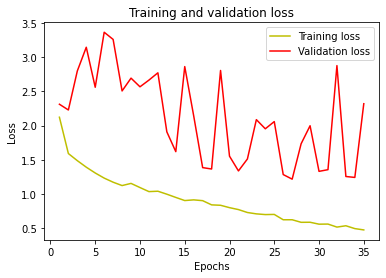

In [120]:
#Train the CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=35, validation_data = (x_test, y_test_one_hot))

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

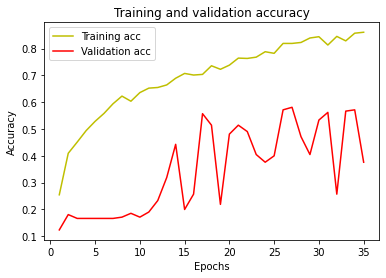

In [121]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [122]:
test_labels = le.inverse_transform(y_test)

In [123]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)
prediction_NN = le.inverse_transform(prediction_NN)

L'echantillon de test contient : 210 articles.
[[ 8  1  2  1 15  0  0]
 [ 0  9  0  1 11  0  0]
 [12  1  4  0 20  0  1]
 [ 2  0  0  4 23  0  1]
 [ 2  1  0  0 32  0  0]
 [ 5  1  2  0 11  6  1]
 [ 4  2  0  1 10  0 16]]


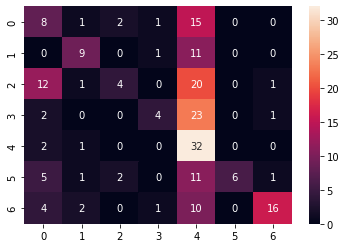

In [124]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, prediction_NN)
print("L'echantillon de test contient :", x_test.shape[0], "articles.")
print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['Home Furnishing']
The actual label for this image is:  Home Furnishing


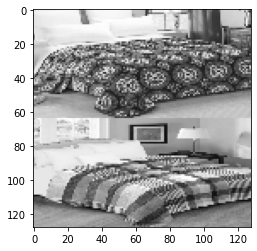

In [125]:
#Check results on a few select images

n=9  #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = np.argmax(cnn_model.predict(input_img))  #argmax to convert categorical back to original
prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", test_labels[n])

In [126]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_NN))

Accuracy =  0.3761904761904762


## Random Forest Classifier

In [127]:
#Now, let us use features from convolutional network for RF
X_for_RF = feature_extractor.predict(x_train) #This is out X input to RF

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

In [128]:
# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

RandomForestClassifier(n_estimators=50, random_state=42)

In [129]:
#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)

In [130]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

Accuracy =  0.6


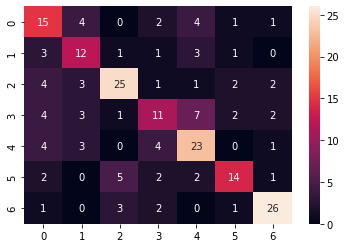

In [131]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

The prediction for this image is:  ['Watches']
The actual label for this image is:  Watches


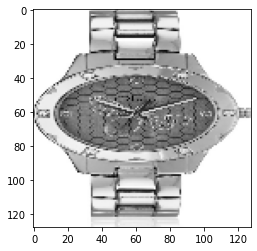

In [132]:
#Check results on a few select images
#n=5 #dog park. RF works better than CNN
n=10 #Select the index of image to be loaded for testing
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_features=feature_extractor.predict(input_img)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])

## KNN

In [133]:
#Now, let us use features from convolutional network for KNN
X_for_KNN = feature_extractor.predict(x_train) #This is out X input to RF

#KNN
from sklearn.neighbors import KNeighborsClassifier
KNN_model = KNeighborsClassifier(n_neighbors=4, n_jobs=4)

In [134]:
# Train the model on training data
KNN_model.fit(X_for_KNN, y_train) #For sklearn no one hot encoding

KNeighborsClassifier(n_jobs=4, n_neighbors=4)

In [135]:
#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_KNN = KNN_model.predict(X_test_feature)
#Inverse le transform to get original label back. 
prediction_KNN = le.inverse_transform(prediction_KNN)

In [136]:
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_KNN))

Accuracy =  0.5952380952380952


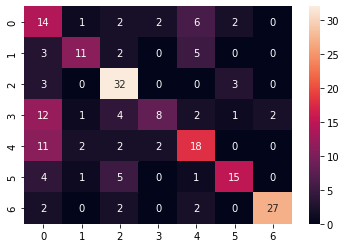

In [137]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(test_labels, prediction_KNN)
#print(cm)
sns.heatmap(cm, annot=True)